# Ensemble with classification

This is an extention to the NLP classifier problem. Basically, I wanted to see if my results would have improve drastically with an ensemble of the top 3 models I used in that analysis. 

My hypothesis would be that it would likely not as the models were already performing very well. 

As this is a practice, not a full project, it will be quick and dirty!!!

Do check out my NLP classifier page for a better idea on what is going on!

## Problem Statement (fictional): 
A virtual reality gaming company has engaged me to help with their advertisements and marketing via a popular social media platform for 2 games: Basketball and Baseball.

The firm is interested in a "per impressions scheme", which enables them to select a user's feed to post the advertisements on and pay by the number of impressions. As prices of advertisements are steep, they want their advertisements to reach out to the right target audience. 

**My goal** is to collect a wealth of text and process it with Natural Language Processing (NLP), and come up with a model that will predict, with high accuracy, which group an audience belongs to so that I can target advertisements(ads) that are specific to the audience. 

In other words, my model will classify if someone falls into these 2 category and targetted ads will be sent to that person via his social media feed. 

In [64]:
import numpy as np 
import pandas as pd 
import time
import requests
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from wordcloud import WordCloud
from matplotlib_venn_wordcloud import venn2_wordcloud

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

### Import data 

I use two seperate notebook to scrap for basketball and baseball subreddits to speed things up after looking at how each json looks like. Below, i import them into the current notebook

In [2]:
df_basket = pd.read_csv('basket.csv')
df_base = pd.read_csv('base.csv')

In [3]:
#shape of the two data set
print("basketball:",df_basket.shape)
print("baseball:",df_base.shape)

basketball: (7397, 106)
baseball: (7348, 106)


In [4]:
#number of unique post for each dataset based on titles
print("basketball:",df_basket['title'].nunique())
print("baseball:",df_base['title'].nunique())

basketball: 932
baseball: 926


In [5]:
#i want only uniques
#check
#nice

df_basket.drop_duplicates(subset='title', keep="first", inplace=True)
df_base.drop_duplicates(subset='title', keep="first", inplace=True)

print(df_basket.shape)
print(df_base.shape)

(932, 106)
(926, 106)


In [6]:
#list of all the columns in the basketball set
list(df_basket.columns)

['approved_at_utc',
 'subreddit',
 'selftext',
 'author_fullname',
 'saved',
 'mod_reason_title',
 'gilded',
 'clicked',
 'title',
 'link_flair_richtext',
 'subreddit_name_prefixed',
 'hidden',
 'pwls',
 'link_flair_css_class',
 'downs',
 'thumbnail_height',
 'hide_score',
 'name',
 'quarantine',
 'link_flair_text_color',
 'author_flair_background_color',
 'subreddit_type',
 'ups',
 'total_awards_received',
 'media_embed',
 'thumbnail_width',
 'author_flair_template_id',
 'is_original_content',
 'user_reports',
 'secure_media',
 'is_reddit_media_domain',
 'is_meta',
 'category',
 'secure_media_embed',
 'link_flair_text',
 'can_mod_post',
 'score',
 'approved_by',
 'author_premium',
 'thumbnail',
 'edited',
 'author_flair_css_class',
 'author_flair_richtext',
 'gildings',
 'content_categories',
 'is_self',
 'mod_note',
 'created',
 'link_flair_type',
 'wls',
 'removed_by_category',
 'banned_by',
 'author_flair_type',
 'domain',
 'allow_live_comments',
 'selftext_html',
 'likes',
 'sugge

In [7]:
#take a look at the df 
df_basket.head(50)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,subreddit_subscribers,created_utc,num_crossposts,media,is_video,crosspost_parent_list,crosspost_parent,post_hint,preview,link_flair_template_id
0,NaN,Basketball,Admins have banned other subs for this. \n\nNo...,t2_aj47j,False,NaN,0,False,Rule: You cannot Ask for or Post Copyright Mat...,[],...,51142,1.571497e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
1,NaN,Basketball,#Welcome to /r/Basketball's weekly Shoe Discus...,t2_6l4z3,False,NaN,0,False,r/Basketball Weekly Discussion: Basketball Sho...,[],...,51142,1.583156e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
2,NaN,Basketball,NaN,t2_azkxwkw,False,NaN,0,False,If a player misses a shot because they were fo...,[],...,51142,1.583448e+09,0,NaN,False,"[{'approved_at_utc': None, 'subreddit': 'NBAan...",t3_fe2ryc,NaN,NaN,NaN
3,NaN,Basketball,NaN,t2_4nis6,False,NaN,0,False,The Kobe Bryant Basketball Workout,[],...,51142,1.583350e+09,0,NaN,False,NaN,NaN,link,{'images': [{'source': {'url': 'https://extern...,NaN
4,NaN,Basketball,I'm a sophmore in highschool I'm 6 feet tall ...,t2_5861c76t,False,NaN,0,False,I'm a sophmore in highschool should I try out ?,[],...,51142,1.583376e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
5,NaN,Basketball,NaN,t2_5s87807v,False,NaN,0,False,New IUBB Reddit Gameday Thread🏀⚪️🔴,[],...,51142,1.583341e+09,0,NaN,False,"[{'approved_at_utc': None, 'subreddit': 'Hoosi...",t3_fd82v8,link,{'images': [{'source': {'url': 'https://extern...,NaN
6,NaN,Basketball,NaN,t2_zi7aq16,False,NaN,0,False,Is the price of homecourt worth it?,[],...,51142,1.583331e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
7,NaN,Basketball,I had recently searched for the “best” basketb...,t2_49ohuddw,False,NaN,0,False,My thoughts/reviews on basketballs (Wilson and...,[],...,51142,1.583290e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
8,NaN,Basketball,Hey guys I need some help I'm a 12 year old ki...,t2_52j8co67,False,NaN,0,False,12 Yo shortest kid,[],...,51142,1.583348e+09,0,NaN,False,NaN,NaN,NaN,NaN,dda4de84-6559-11e6-9994-0e4704e28925
9,NaN,Basketball,"I'm 14, male, 6'0"" , 86kgs.\n\nI'm trying to b...",t2_15171s,False,NaN,0,False,Im 14 and trying to build a better basketball ...,[],...,51142,1.583317e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN


In [8]:
#theres this ad in the actual website but it is not present here
(df_basket['title']=="Are you the most security-aware developer").value_counts()

False    932
Name: title, dtype: int64

## EDA & CLEANING 

EDA before splitting:

We should clearly understand the data before splitting. Clearly understanding the data helps in knowing which attributes to consider for building the model.

Another reason to do EDA before splitting is that we have explore the missing and outliers.

### Cleaning

In [9]:
#I wanted to see if this will help us identify if a post contains a picture or a video
#this obviously doesnt mean that the post only contain video or picture

print(df_basket['media_only'].count())
print(df_base['media_only'].count())

932
926


In [10]:
#i want to select a few columns that i tought may give us additional info about the data
#it seems like distinguished is a column that tells us if the post was by a moderator
#as post by moderator may not be an actual post, i will choose to remove them 
#first post need to be removed because it seems like just a group rule

df_basket[['author_fullname', 'selftext', 'title', 'name', 'user_reports', 'distinguished', 'author_flair_css_class','content_categories',]].head(50)

,author_fullname,selftext,title,name,user_reports,distinguished,author_flair_css_class,content_categories
0,t2_aj47j,Admins have banned other subs for this. \n\nNo...,Rule: You cannot Ask for or Post Copyright Mat...,t3_dk4qe2,[],NaN,NaN,NaN
1,t2_6l4z3,#Welcome to /r/Basketball's weekly Shoe Discus...,r/Basketball Weekly Discussion: Basketball Sho...,t3_fcc4h8,[],moderator,ballflair,NaN
2,t2_azkxwkw,NaN,If a player misses a shot because they were fo...,t3_fe3gpl,[],NaN,NaN,NaN
3,t2_4nis6,NaN,The Kobe Bryant Basketball Workout,t3_fdib5q,[],NaN,NaN,NaN
4,t2_5861c76t,I'm a sophmore in highschool I'm 6 feet tall ...,I'm a sophmore in highschool should I try out ?,t3_fdokwk,[],NaN,NaN,NaN
5,t2_5s87807v,NaN,New IUBB Reddit Gameday Thread🏀⚪️🔴,t3_fdfsoj,[],NaN,NaN,NaN
6,t2_zi7aq16,NaN,Is the price of homecourt worth it?,t3_fddf0x,[],NaN,NaN,NaN
7,t2_49ohuddw,I had recently searched for the “best” basketb...,My thoughts/reviews on basketballs (Wilson and...,t3_fd67v2,[],NaN,NaN,NaN
8,t2_52j8co67,Hey guys I need some help I'm a 12 year old ki...,12 Yo shortest kid,t3_fdhq54,[],NaN,NaN,NaN
9,t2_15171s,"I'm 14, male, 6'0"" , 86kgs.\n\nI'm trying to b...",Im 14 and trying to build a better basketball ...,t3_fdb0uy,[],NaN,NaN,NaN


In [11]:
df_basket['distinguished'].value_counts()

moderator    11
Name: distinguished, dtype: int64

In [12]:
#dropped the rules

df_basket.drop(index=0, axis=0, inplace=True)
df_basket.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,subreddit_subscribers,created_utc,num_crossposts,media,is_video,crosspost_parent_list,crosspost_parent,post_hint,preview,link_flair_template_id
1,NaN,Basketball,#Welcome to /r/Basketball's weekly Shoe Discus...,t2_6l4z3,False,NaN,0,False,r/Basketball Weekly Discussion: Basketball Sho...,[],...,51142,1.583156e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
2,NaN,Basketball,NaN,t2_azkxwkw,False,NaN,0,False,If a player misses a shot because they were fo...,[],...,51142,1.583448e+09,0,NaN,False,"[{'approved_at_utc': None, 'subreddit': 'NBAan...",t3_fe2ryc,NaN,NaN,NaN
3,NaN,Basketball,NaN,t2_4nis6,False,NaN,0,False,The Kobe Bryant Basketball Workout,[],...,51142,1.583350e+09,0,NaN,False,NaN,NaN,link,{'images': [{'source': {'url': 'https://extern...,NaN
4,NaN,Basketball,I'm a sophmore in highschool I'm 6 feet tall ...,t2_5861c76t,False,NaN,0,False,I'm a sophmore in highschool should I try out ?,[],...,51142,1.583376e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
5,NaN,Basketball,NaN,t2_5s87807v,False,NaN,0,False,New IUBB Reddit Gameday Thread🏀⚪️🔴,[],...,51142,1.583341e+09,0,NaN,False,"[{'approved_at_utc': None, 'subreddit': 'Hoosi...",t3_fd82v8,link,{'images': [{'source': {'url': 'https://extern...,NaN


In [13]:
#dropped those that are by the moderator
df_basket=df_basket[df_basket['distinguished']!='moderator']

In [14]:
#see how many post are by moderators for the baseball set
df_base['distinguished'].value_counts()

moderator    1
Name: distinguished, dtype: int64

In [15]:
df_base[['author_fullname', 'selftext', 'title', 'name', 'user_reports', 'distinguished', 'author_flair_css_class','content_categories',]].head(50)

,author_fullname,selftext,title,name,user_reports,distinguished,author_flair_css_class,content_categories
0,t2_8364z,#So what's this thread for?\r\n\r\n* Discussio...,[General Discussion] Around the Horn - 3/6/20,t3_fecsr9,[],NaN,umpire,NaN
1,t2_8364z,### Line Score - Final\n\n| |1|2|3|4|5|6|7|8|9...,Postgame Thread ⚾ Cardinals 11 @ Nationals 0,t3_fe69d4,[],NaN,umpire,NaN
2,t2_4hzyqny4,I had an original post about 1-2 months ago sa...,Thank you all for helping me (14m) realize wha...,t3_fe5dl2,[],NaN,min-2,NaN
3,t2_1zeimkjc,NaN,[Darvish] Yu Darvish started coughing so his s...,t3_fe2fhm,[],NaN,lad,NaN
4,t2_hdbqu,NaN,[Pensacola Blue Wahoos] Due to an unfortunate ...,t3_fdv4rc,[],NaN,min-2,NaN
5,t2_ixhni,NaN,[Nightengale] The Christian Yelich $188.5 mill...,t3_fe3bdp,[],NaN,tor,NaN
6,t2_3jk7n2i9,NaN,Assuming MLB The Show 20’s depiction is accura...,t3_fe6hp6,[],NaN,was,NaN
7,t2_e9bjc,NaN,[Rosenthal] 3B Yoan Moncada in agreement with ...,t3_fe1vgr,[],NaN,NaN,NaN
8,t2_pztax,NaN,Angels fire employee for allegedly furnishing ...,t3_fe59e1,[],NaN,sfg-1,NaN
9,t2_z9a4q,"This weird, extremely rare feat was accomplish...",Demeritte and Cabrera go back-to-back off Cole...,t3_fe0059,[],NaN,tor,NaN


In [16]:
#drop post by moderator 
df_base=df_base[df_base['distinguished']!='moderator']

In [17]:
#the data we are interested in is the selftext
#but it is not a big set of data
#we can used the titles as well as they are also valuable text information
#moreover, some post may not contain selftext 

print("basketball:",df_basket['selftext'].count())
print("baseball:",df_base['selftext'].count())

basketball: 804
baseball: 318


In [18]:
#there is a 61% difference in samples, very big difference
print("% diff in sample size:", 495/814 ) 

% diff in sample size: 0.6081081081081081


The column we are most interested in is selftext
it is quite imbalance. Baseball has about 60% lesser self text. This is because some post are only titles or titles and a photo without subtext. 



In [19]:
#we will use titles too since they are text 

print("basketball:",df_basket['title'].count())
print("baseball:",df_base['title'].count())

basketball: 920
baseball: 925


In [20]:
print('total basketball sample size:', 814+931)
print('total baseball sample size:', 319+925)

total basketball sample size: 1745
total baseball sample size: 1244


In [21]:
#if we combine the columns, the difference is 501
print("% diff in sample size:", 1745-1244)

% diff in sample size: 501


In [22]:
#the difference is smaller now, about 29%, this is easier to work with
501/1745  

0.2871060171919771

In [23]:
#create data frame with only variables of interest

df_basket_st = pd.DataFrame(df_basket, columns = ['subreddit', 'selftext'])
df_base_st = pd.DataFrame(df_base, columns = ['subreddit', 'selftext'])
df_basket_title = pd.DataFrame(df_basket, columns = ['subreddit', 'title'])
df_base_title = pd.DataFrame(df_base, columns = ['subreddit', 'title'])

#rename to concat
df_basket_st.rename(columns={'subreddit':'source', 'selftext':'text'}, inplace=True)
df_base_st.rename(columns={'subreddit':'source', 'selftext':'text'}, inplace=True)
df_basket_title.rename(columns={'subreddit':'source', 'title':'text'}, inplace=True)
df_base_title.rename(columns={'subreddit':'source', 'title':'text'}, inplace=True)


In [24]:
df_basket_st.head(10)

,source,text
2,Basketball,NaN
3,Basketball,NaN
4,Basketball,I'm a sophmore in highschool I'm 6 feet tall ...
5,Basketball,NaN
6,Basketball,NaN
7,Basketball,I had recently searched for the “best” basketb...
8,Basketball,Hey guys I need some help I'm a 12 year old ki...
9,Basketball,"I'm 14, male, 6'0"" , 86kgs.\n\nI'm trying to b..."
10,Basketball,NaN
11,Basketball,My biggest problem with going anywhere to play...


In [25]:
df_base_st.head(10)

,source,text
0,baseball,#So what's this thread for?\r\n\r\n* Discussio...
1,baseball,### Line Score - Final\n\n| |1|2|3|4|5|6|7|8|9...
2,baseball,I had an original post about 1-2 months ago sa...
3,baseball,NaN
4,baseball,NaN
5,baseball,NaN
6,baseball,NaN
7,baseball,NaN
8,baseball,NaN
9,baseball,"This weird, extremely rare feat was accomplish..."


In [26]:
df_basket_title.head(10)

,source,text
2,Basketball,If a player misses a shot because they were fo...
3,Basketball,The Kobe Bryant Basketball Workout
4,Basketball,I'm a sophmore in highschool should I try out ?
5,Basketball,New IUBB Reddit Gameday Thread🏀⚪️🔴
6,Basketball,Is the price of homecourt worth it?
7,Basketball,My thoughts/reviews on basketballs (Wilson and...
8,Basketball,12 Yo shortest kid
9,Basketball,Im 14 and trying to build a better basketball ...
10,Basketball,Elena Delle Donne here! I’m the reigning WNBA ...
11,Basketball,Is there some sort of product out there in the...


In [27]:
df_base_title.head(10)

,source,text
0,baseball,[General Discussion] Around the Horn - 3/6/20
1,baseball,Postgame Thread ⚾ Cardinals 11 @ Nationals 0
2,baseball,Thank you all for helping me (14m) realize wha...
3,baseball,[Darvish] Yu Darvish started coughing so his s...
4,baseball,[Pensacola Blue Wahoos] Due to an unfortunate ...
5,baseball,[Nightengale] The Christian Yelich $188.5 mill...
6,baseball,Assuming MLB The Show 20’s depiction is accura...
7,baseball,[Rosenthal] 3B Yoan Moncada in agreement with ...
8,baseball,Angels fire employee for allegedly furnishing ...
9,baseball,Demeritte and Cabrera go back-to-back off Cole...


In [28]:
#combine all 4 to a full dataset with basketball & baseball's title and selftext

list_of_df = [df_basket_st, df_base_st, df_basket_title, df_base_title]
basket= [df_basket_st,df_basket_title]
base= [df_base_st,df_base_title]

full_df=pd.concat(list_of_df, ignore_index=True)
basket_df=pd.concat(basket, ignore_index=True)
base_df=pd.concat(base, ignore_index=True)

full_df.head(10)

,source,text
0,Basketball,NaN
1,Basketball,NaN
2,Basketball,I'm a sophmore in highschool I'm 6 feet tall ...
3,Basketball,NaN
4,Basketball,NaN
5,Basketball,I had recently searched for the “best” basketb...
6,Basketball,Hey guys I need some help I'm a 12 year old ki...
7,Basketball,"I'm 14, male, 6'0"" , 86kgs.\n\nI'm trying to b..."
8,Basketball,NaN
9,Basketball,My biggest problem with going anywhere to play...


In [29]:
full_df.shape

(3690, 2)

In [30]:
full_df.isnull().sum()

source      0
text      723
dtype: int64

In [31]:
#keep only those with text. drop NaN

full_df.dropna(axis=0, inplace=True)

In [32]:
full_df.isnull().sum()

source    0
text      0
dtype: int64

In [33]:
#as shown above in manual calculation, 
#after removing the empty text, this is the figures of our sample size

full_df['source'].value_counts()

Basketball    1724
baseball      1243
Name: source, dtype: int64

In [34]:
#code the source column such that 1 is basketball and 0 is baseball

full_df['source'] = full_df['source'].map(lambda s: 1 if s=='Basketball' else 0)


In [35]:
full_df.head()

,source,text
2,1,I'm a sophmore in highschool I'm 6 feet tall ...
5,1,I had recently searched for the “best” basketb...
6,1,Hey guys I need some help I'm a 12 year old ki...
7,1,"I'm 14, male, 6'0"" , 86kgs.\n\nI'm trying to b..."
9,1,My biggest problem with going anywhere to play...


In [36]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2967 entries, 2 to 3689
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  2967 non-null   int64 
 1   text    2967 non-null   object
dtypes: int64(1), object(1)
memory usage: 69.5+ KB


Thus far, missing data and duplicates were removed. 
I also cleaned out the rule post in the basketball dataframe. 
The baseball dataframe had none. 
I searched if the post contains advertisements. I also removed post by the moderator.

I decided to combined selftext and title into a single column as our text as both are valuable text information. The total number of rows are summarized as follow:
- total basketball sample size: 1745
- total baseball sample size: 1244

The difference in sample size is about 29% and the whole set has 3690 samples. The subreddit has been renamed 'source' to identify where the data was from. The source is our dependent variable. 


In [37]:
#define X and y

X=full_df['text'].str.lower()
y=full_df['source']


In [38]:
#we dont really want the hyperlink things like www , https, .com
#but the text inside it might be useful
#eg. hhtps://www.nba.com/supershot 
#"nba" and "supershot" is a useful discriminator 

hyperlink_words= ['www', 'com', 'http', 'https', 'jsp', '']


In [39]:

my_stopwords= stopwords.words('english')
my_stopwords.extend(hyperlink_words)

my_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [40]:
lemmatizer =WordNetLemmatizer()
def lem(text):
    [lemmatizer.lemmatize(i) for i in text]
    return (text)


In [41]:
#instantiate 

cvec=CountVectorizer(preprocessor=lem, stop_words = my_stopwords)

I identify the X and y variable as per discussed, the text column is the X and y is the source, with basketball coded as 1. I defined additional stopwords which are mainly hyperlink components like www , https, .com. The text inside it might be useful and thus was retained (eg. hhtps://www.nba.com/supershot , "nba" and "supershot" may be useful discriminators. Note: the hyperlink example is made up for the purpose of illustration only)

### EDA

#### Words that stand out from the Basketball corpus

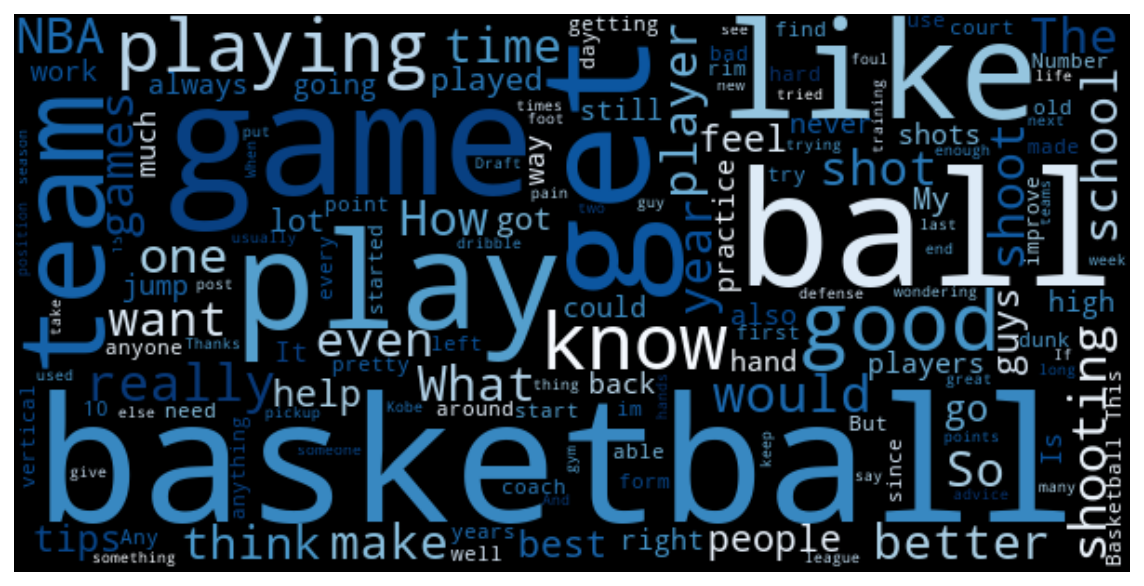

In [42]:
#word cloud of basketball corpus

basket_df.dropna(inplace=True)
basket_cvec = cvec.fit_transform(basket_df['text']).todense()
basket_c_df = pd.DataFrame(basket_cvec, columns = cvec.get_feature_names())
basket_c_df.loc['Total',:]= basket_c_df.sum(axis=0)
basket_c_total = pd.DataFrame(basket_c_df.loc['Total',:].sort_values(ascending=False))

wc_basket = basket_c_total.reset_index(drop=False, inplace=False)
wc_dict_basket = dict(zip(wc_basket['index'].tolist(), wc_basket['Total'].tolist()))


wc = WordCloud(background_color='black', 
               width=600, height=300, 
               max_words=150, colormap='Blues').generate_from_frequencies(wc_dict_basket)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

This are some of the words that stand out in the Basketball corpus. 

#### Words that stand out from the Baseball corpus

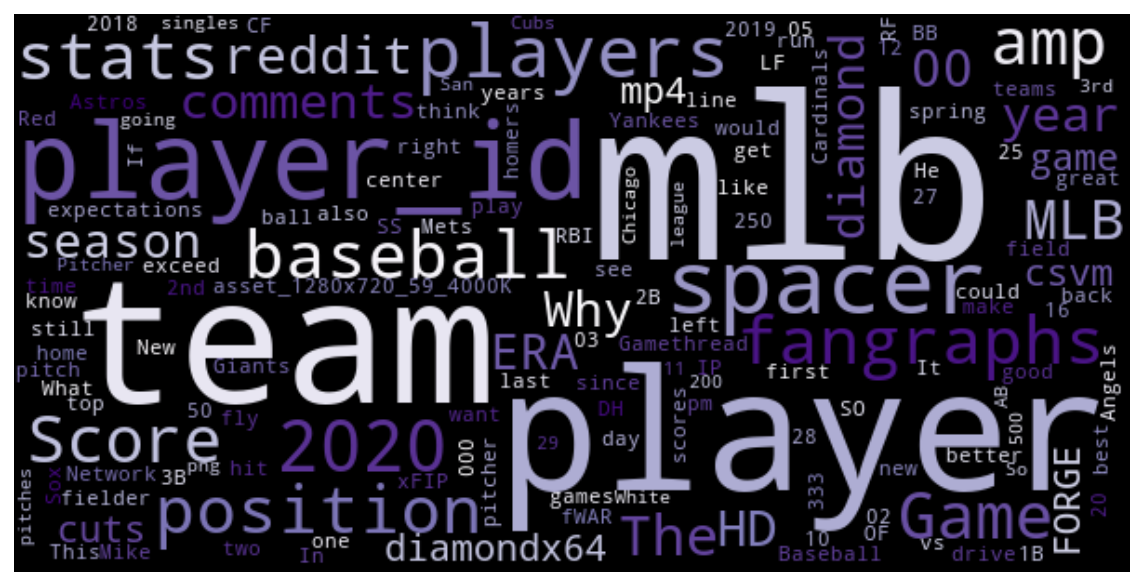

In [43]:
#word cloud of baseball corpus

base_df.dropna(inplace=True)
base_cvec = cvec.fit_transform(base_df['text']).todense()
base_c_df = pd.DataFrame(base_cvec, columns = cvec.get_feature_names())
base_c_df.loc['Total',:]= base_c_df.sum(axis=0)
base_c_total = pd.DataFrame(base_c_df.loc['Total',:].sort_values(ascending=False))

wc_base = base_c_total.reset_index(drop=False, inplace=False)
wc_dict_base = dict(zip(wc_base['index'].tolist(), wc_base['Total'].tolist()))


wc = WordCloud(background_color='black', 
               width=600, height=300, 
               max_words=150, colormap='Purples_r').generate_from_frequencies(wc_dict_base)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

This are some of the words that stand out in the Baseball corpus.

#### Words that stand out from the combined corpus 

In [44]:
#use cvec to preprocess the words
#row should still match with y

X_cvec = cvec.fit_transform(X).todense()
X_cvec_df = pd.DataFrame(X_cvec, columns = cvec.get_feature_names())


print(X_cvec_df.shape)
print(y.shape)

(2967, 12650)
(2967,)


In [45]:
# find out how many times each word appear in the corpus by creating a 'Total' row at the end of the dataframe:
X_cvec_df.loc['Total',:]= X_cvec_df.sum(axis=0) #sum by row
X_cvec_df.loc['Total',:].sort_values(ascending=False)

mlb              3136.0
team             1888.0
player           1651.0
player_id        1308.0
game             1041.0
                  ...  
installable         1.0
installations       1.0
installed           1.0
instance            1.0
hiring              1.0
Name: Total, Length: 12650, dtype: float64

In [46]:
#20 most common words 

X_cvec_total = pd.DataFrame(X_cvec_df.loc['Total',:].sort_values(ascending=False))
X_cvec_total.head(20)

,Total
mlb,3136.0
team,1888.0
player,1651.0
player_id,1308.0
game,1041.0
spacer,924.0
players,753.0
ball,610.0
basketball,594.0
2020,555.0


In [47]:
#20 least common words
#least common word may be useful discriminators for all we know

X_cvec_total = pd.DataFrame(X_cvec_df.loc['Total',:].sort_values(ascending=True))
X_cvec_total.head(20)

,Total
hiring,1.0
instance,1.0
installed,1.0
installations,1.0
installable,1.0
insole,1.0
insights,1.0
insightful,1.0
inquiry,1.0
inquiring,1.0


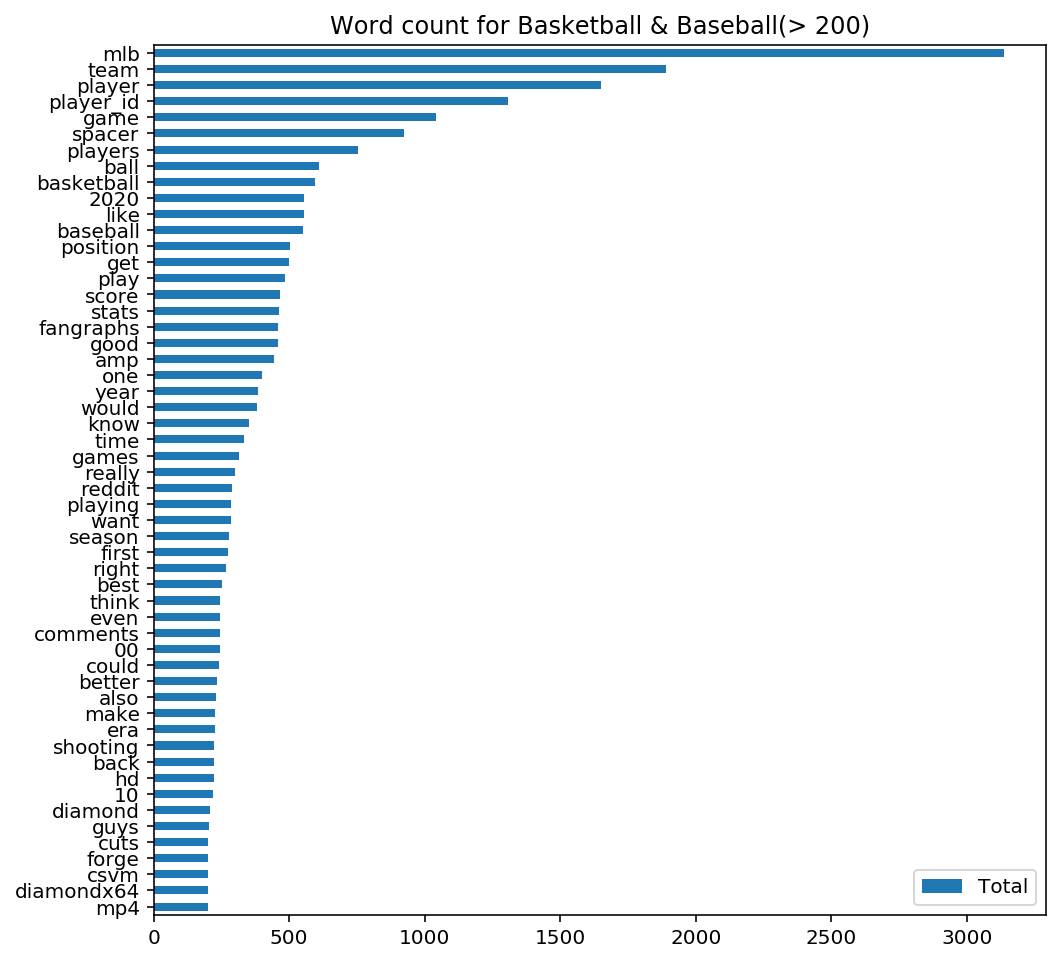

In [48]:
#plot words with more than 200 counts

X_cvec_total[X_cvec_total.Total > 200].plot(kind='barh',figsize = (8,8),  title="Word count for Basketball & Baseball(> 200)");


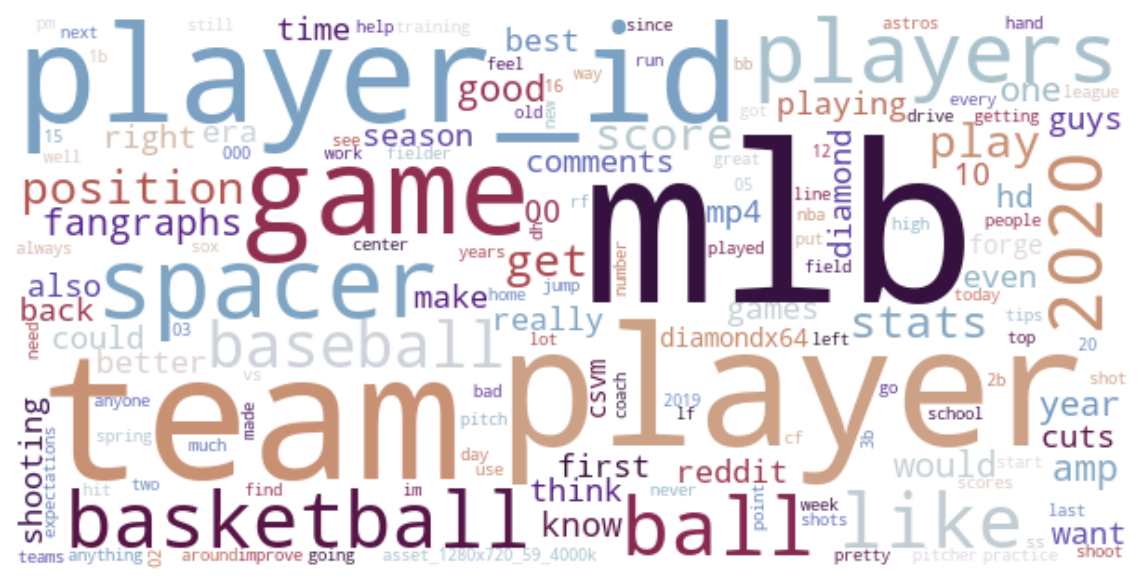

In [49]:
wc_df = X_cvec_total.reset_index(drop=False, inplace=False)


wc_dict = dict(zip(wc_df['index'].tolist(), wc_df['Total'].tolist()))



wc = WordCloud(background_color='white', 
               width=600, height=300, 
               max_words=150, colormap='twilight_r').generate_from_frequencies(wc_dict)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Some words like MLB, team, player are very high in frequency as compared to the other words. 

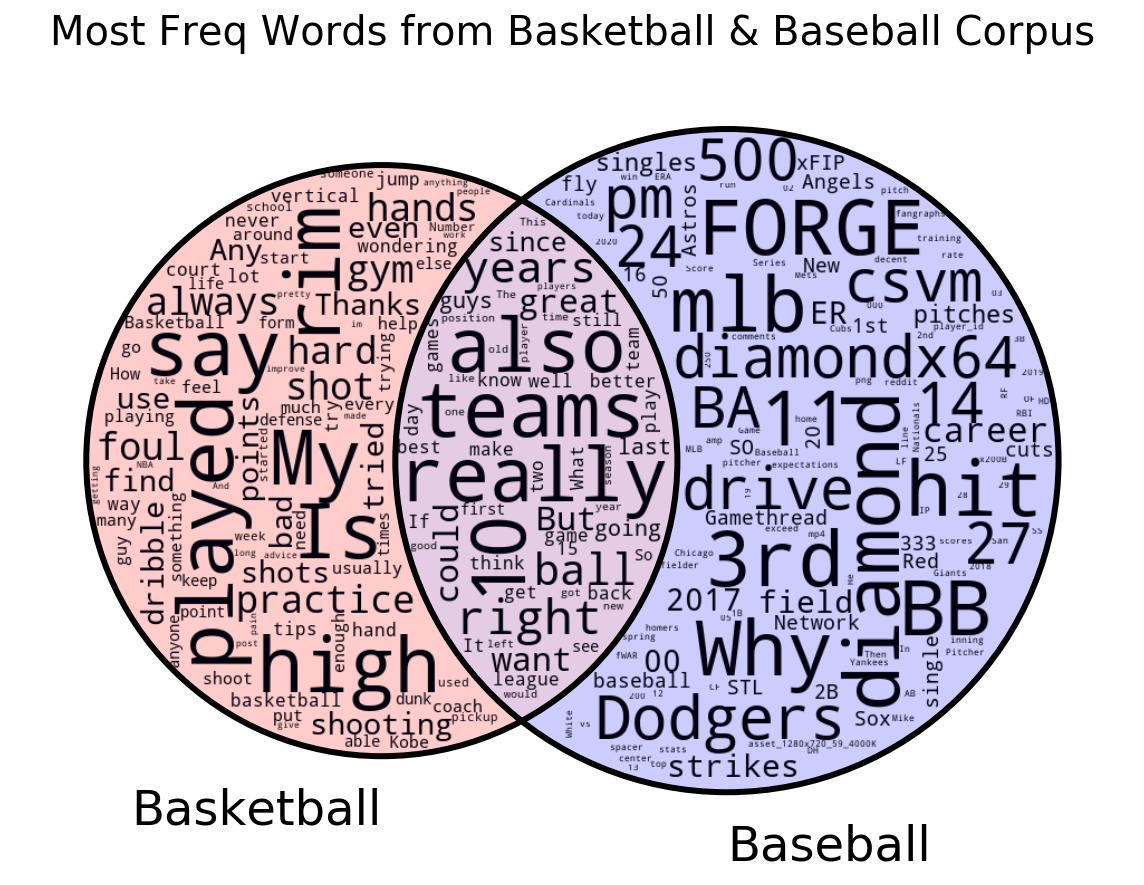

In [50]:
#take out the keys for those with more than 100 occurance
wc_dict_basket_v = { key:value for (key,value) in wc_dict_basket.items() if value > 50}
wc_dict_base_v = { key:value for (key,value) in wc_dict_base.items() if value > 50}

#plot the wc
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Most Freq Words from Basketball & Baseball Corpus', fontsize=20)

v = venn2_wordcloud([set(wc_dict_basket_v.keys()), set(wc_dict_base_v.keys())],
                    ax=ax, 
                    set_labels=['Basketball', 'Baseball'])


# add color
v.get_patch_by_id('10').set_color('red')
v.get_patch_by_id('10').set_alpha(0.2)
v.get_patch_by_id('01').set_color('blue')
v.get_patch_by_id('01').set_alpha(0.2)
v.get_patch_by_id('11').set_color('purple')
v.get_patch_by_id('11').set_alpha(0.2)

We take a closer look at words that occur in the Basketball corpus and in the Baseball corpus and in both through a venn diagram that plots only words occuring more than 50 times.
Those in both corpus will not be discriminators while those in only one corpus may be good discriminators

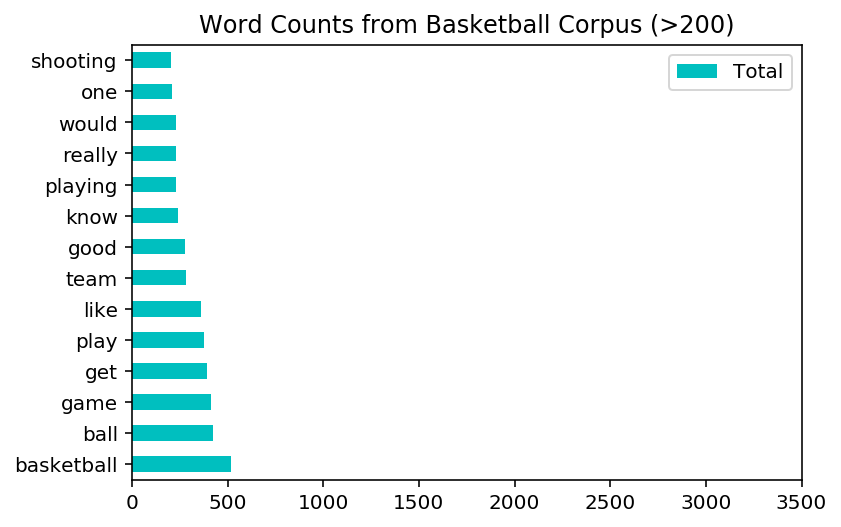

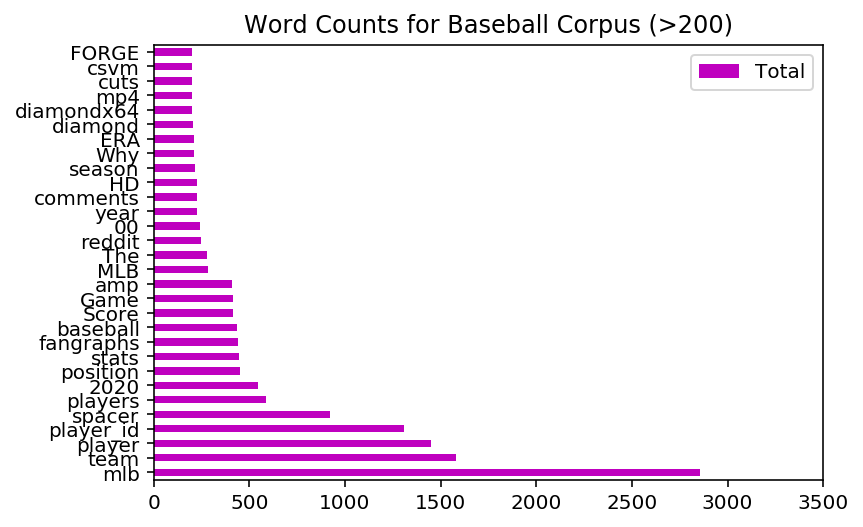

In [51]:
basket_c_total[basket_c_total['Total'] > 200].plot(kind='barh', color="c", xlim=(0,3500), title="Word Counts from Basketball Corpus (>200)");

base_c_total[base_c_total['Total'] > 200].plot(kind='barh', color="m",xlim=(0,3500),  title="Word Counts for Baseball Corpus (>200)");

We see that although there are more samples of basketball, the baseball corpus has more frequently repeated words above 200 counts. 

## PRE-MODELING 

### Seperate training set and put aside a test set

In [52]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

### Establish baseline score

In [53]:
y_train.value_counts(normalize=True)

1    0.581124
0    0.418876
Name: source, dtype: float64

## MODELING

I will be testing a total of 6 models. First, using countvectorizer then TFIDF vectorizer on a logistic regression. Then, using countvectorizer then TFIDF vectorizer on K-nearest neighbor. Finally, using countvectorizer then TFIDF vectorizer on a Naive Bayes classifier. 

While the countvectorizer simply counts the term's frequencies, the TFIDF vectorizer helps to account for words that appear mor frequently. The TFIDF is intended to reflect how important a word is to a document in a collection or corpus. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. 

Because some terms are so common, term frequency will tend to incorrectly emphasize documents which happen to use thse word more frequently, without giving enough weight to the more meaningful terms that may appear less frequently. Terms that occur too frequently may not be good discriminators. For example, if a term occurs in every document of baseball and basketball (eg, maybe a word in the middle of our venn diagram), it simply isnt something that can help us differentiate anything. 

Hence an inverse document frequency factor is incorporated which diminishes the weight of terms that occur too frequently in the document set and increases the weight of terms that occur rarely.

A pipeline will be built at the start of each type of classifier. A Randomized Search CV will be used to find the best hyper-parameters out of those I defined. After which, i printed accuracy scores for the cross validation, the train and the test. I then calculated other classification metrics with the test set. 

### Logistic regression

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable (similar to how a linear regression works, expect the dependent variable is now in log odds)

In [54]:
#create pipeline

lr_cvec_pipe = Pipeline([
    ("cvec", CountVectorizer(preprocessor=lem, 
                             stop_words = my_stopwords,
                            max_features = 700,
                            min_df = 5,
                            max_df= 0.9,
                            ngram_range = (1,1))),
    ("lr", LogisticRegression(penalty = 'l2', 
                              C = 0.7924828983539169,
                             solver = 'liblinear'))])

In [55]:
#log reg with cvec
lr_cvec_pipe.fit(X_train, y_train)

print("Count vectorizer Logistic regression accuracy scores")
print("train score:", lr_cvec_pipe.score(X_train, y_train))
print("test score:", lr_cvec_pipe.score(X_test, y_test))

Count vectorizer Logistic regression accuracy scores
train score: 0.9532584269662921
test score: 0.8962264150943396


### Multinomial Naive Bayes

naïve Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features.

Bayes theorem tells us that the probability of a hypothesis given some evidence is equal to the probability of the hypothesis multiplied by the probability of the evidence given the hypothesis, then divided by the probability of the evidence.

In essence, NB uses a simplification of a Bayes theorem to calculate the probability of a class base on the words. 

In [56]:
nb_tvec_pipe = Pipeline([
    ("tvec", TfidfVectorizer(preprocessor=lem, 
                             stop_words = my_stopwords,
                            max_features = 800,
                            min_df = 4,
                            max_df = 0.95,
                            ngram_range = (1,1))),
    ("nb", MultinomialNB())])



In [57]:
#naive bayes with cvec
nb_tvec_pipe.fit(X_train, y_train)

print("TFIDF vectorizer nb accuracy scores")

print("train score:", nb_tvec_pipe.score(X_train, y_train))
print("test score:", nb_tvec_pipe.score(X_test, y_test))

TFIDF vectorizer nb accuracy scores
train score: 0.9258426966292135
test score: 0.9002695417789758


### XGBoost 
The general idea of any gradient boosting classifiers are similar to AdaBoosting method combined with weighted minimization, after which the classifiers and weighted inputs are recalculated. The objective of Gradient Boosting classifiers is to minimize the loss, or the difference between the actual class value of the training example and the predicted class value.

In the case of Gradient Boosting Machines, every time a new weak learner is added to the model, the weights of the previous learners are frozen or cemented in place, left unchanged as the new layers are introduced. This is distinct from the approaches used in AdaBoosting where the values are adjusted when new learners are added.

It starts with a single leaf (naive model) then fit to pseudo residuals (negative of deriavative of squared loss, which is also where the word gradient comes from as gradient is deriavative). Then scale the trees prediction to the learning rate. Then add another tree and continue this step.

In [58]:
xg_cvec_pipe = Pipeline([
    ("cvec", CountVectorizer(preprocessor=lem, 
                             stop_words = my_stopwords,
                            max_features = 800,
                            min_df = 5,
                            max_df= 0.95,
                            ngram_range = (1,2))),
    ("xg", XGBClassifier(max_depth = 5,
                        n_estimators = 300))])


In [59]:
#xgb with cvec
xg_cvec_pipe.fit(X_train, y_train)

print("Cvec Vectorizer xg accuracy scores")
print("train score:",xg_cvec_pipe.score(X_train, y_train))
print("test score:", xg_cvec_pipe.score(X_test, y_test))

Cvec Vectorizer xg accuracy scores
train score: 0.9298876404494382
test score: 0.8935309973045822


## ENSEMBLE 

### Max voting

In [62]:
from sklearn.ensemble import VotingClassifier

model1 = lr_cvec_pipe
model2 = nb_tvec_pipe
model3= xg_cvec_pipe

model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)

model = VotingClassifier(estimators=[('lr', model1), 
                                     ('nb', model2),
                                     ('xg', model3)], 
                         voting='hard')

model.fit(X_train,y_train)



VotingClassifier(estimators=[('lr',
                              Pipeline(memory=None,
                                       steps=[('cvec',
                                               CountVectorizer(analyzer='word',
                                                               binary=False,
                                                               decode_error='strict',
                                                               dtype=<class 'numpy.int64'>,
                                                               encoding='utf-8',
                                                               input='content',
                                                               lowercase=True,
                                                               max_df=0.9,
                                                               max_features=700,
                                                               min_df=5,
                                                     

In [65]:
kf=KFold(n_splits=5, shuffle=True, random_state=42)

print("Ensemble accuracy scores")
print("train score:",model.score(X_train, y_train))
print("cross val score:", cross_val_score(model, X_train, y_train, cv= kf).mean())
print("test score:", model.score(X_test, y_test))

Ensemble accuracy scores
train score: 0.9456179775280898
cross val score: 0.901123595505618
test score: 0.9070080862533693


Here I try to run an ensemble to see if the model can be improved even further. It seems like it did improve a little.

As this is just my personal quick practice, i will not be doing a full evaluation with a classification metrics and a ROC curve. 